In [ ]:
from google.colab import drive
# drive.mount('/content/drive/MyDrive/IITP/sohyun/creditcard_prediction/data')
drive.mount('/content/drive')

%cd drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/data/modify

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1j1N0u5t0l99N_wfSd5UZvnhugzn5g_NC/TimeSeriesAnomaly/data/modify


In [ ]:
import matplotlib.pyplot as plt
import easydict
from sklearn.preprocessing import StandardScaler
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import time
import math

## Data 

In [ ]:
#---# LOAD npy file #---#
Fu_20_normal = np.load('Fu_20_normal.npy')
Fu_21_normal = np.load('Fu_21_normal.npy')
Fu_21_abnormal = np.load('Fu_21_abnormal.npy')
Fu_22_normal = np.load('Fu_22_normal.npy')
Fu_22_abnormal = np.load('Fu_22_abnormal.npy')

Fu_20_normal_10 = np.load('Fu_20_normal_10.npy')
Fu_21_normal_10 = np.load('Fu_21_normal_10.npy')
Fu_21_abnormal_10 = np.load('Fu_21_abnormal_10.npy')
Fu_22_normal_10 = np.load('Fu_22_normal_10.npy')
Fu_22_abnormal_10 = np.load('Fu_22_abnormal_10.npy')

# import sys
# np.set_printoptions(threshold=sys.maxsize) # print all

#---# 확인용 #---#
# plt.figure(figsize=(30,5))
# plt.plot(Fu_22_abnormal_10)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class MyDataset(Dataset):
  def __init__(self, data):
    self.data = np.array(self.sliding_window(data, config.window_size, config.stride))
    self.data = self.data.reshape(-1, config.window_size)
    
  def __getitem__(self, index):
    self.x = self.data[index]
    return (index, torch.Tensor(self.x))
      
  def __len__(self):
    return len(self.data)

  #---# Window #---#
  def sliding_window(self, arr, window_size, stride):
    start_pt = 0
    total_data = []
    while(True) :
      if len(arr) < (start_pt + window_size) : break
      data = arr[start_pt:start_pt+window_size]
      start_pt += stride
      total_data.append(data)
    return total_data

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.Encoder = nn.Sequential(
      nn.Linear(config.window_size,200),
      nn.BatchNorm1d(200),
      nn.LeakyReLU(),
      nn.Linear(200,100),
      nn.BatchNorm1d(100),
      # nn.LeakyReLU(),
      # nn.Linear(100,50),
      # nn.BatchNorm1d(50),

      # nn.LeakyReLU(),
      # nn.Linear(100,50),
      # nn.BatchNorm1d(50),
      nn.LeakyReLU()
    )
    self.Decoder = nn.Sequential(
      # nn.Linear(50,100),
      # nn.BatchNorm1d(100),
      # nn.LeakyReLU(),
      nn.Linear(100,200),
      nn.BatchNorm1d(200),
      nn.LeakyReLU(),
      # nn.Linear(100,200),
      # nn.BatchNorm1d(200),
      # nn.LeakyReLU(),
      # nn.Linear(200,400),
      # nn.BatchNorm1d(400),
      # nn.LeakyReLU(),
      nn.Linear(200,config.window_size),
    )

    #####
    # self.Encoder = nn.Sequential(
    #   nn.Linear(config.window_size, 2*config.window_size),
    #   nn.BatchNorm1d(2*config.window_size),
    #   nn.LeakyReLU(),
    #   nn.Linear(2*config.window_size, 4*config.window_size),
    #   nn.BatchNorm1d(4*config.window_size),
    #   nn.LeakyReLU(),
    #   # nn.Linear(4*config.window_size, 8*config.window_size),
    #   # nn.BatchNorm1d(8*config.window_size),
    #   # nn.LeakyReLU()
    # )
    # self.Decoder = nn.Sequential(
    #   # nn.Linear(8*config.window_size, 4*config.window_size),
    #   # nn.BatchNorm1d(4*config.window_size),
    #   # nn.LeakyReLU(),
    #   nn.Linear(4*config.window_size, 2*config.window_size),
    #   nn.BatchNorm1d(2*config.window_size),
    #   nn.LeakyReLU(),
    #   nn.Linear(2*config.window_size, config.window_size),
    # )
    
  def forward(self, x):
    x = self.Encoder(x)
    x = self.Decoder(x)
    return x

class Trainer():
  def __init__(self, model, optimizer, train_loader, scheduler, device):
    self.model = model
    self.optimizer = optimizer
    self.train_loader = train_loader
    self.scheduler = scheduler
    self.device = device
    # Loss Function
    # self.criterion = nn.L1Loss().to(self.device) ## L1 loss
    self.criterion = nn.CrossEntropyLoss().to(self.device) ## L2 loss
      
  def fit(self) :
    self.model.to(self.device)
    best_score = 0
    for epoch in range(config.num_epochs):
      self.model.train()
      train_loss = []
      for idx, x in iter(self.train_loader):
        x = x.float().to(self.device)
        self.optimizer.zero_grad()
        
        _x = self.model(x)
        loss = self.criterion(x, _x)
        
        loss.backward()
        self.optimizer.step()

        train_loss.append(loss.item())
  
  def test(self, test_loader, thr) :
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    # eval_model.eval()
    pred = []; true = []
    xs = []; _xs = []
    predictions = []
    total_num = math.floor((test.shape[0] - config.window_size) / config.stride)

    self.model.eval()
    with torch.no_grad():
      for idx, x in iter(test_loader):
        x = x.float().to(self.device) # x shape : (batch_size, window_size)
        _x = self.model(x) # prediction
        
        for i in range(x.shape[0]) : # batch_size만큼 돌면서 stride씩만 저장
          if (idx[-1] == total_num) and (i == x.shape[0] - 1) : # 마지막 데이터는 전체 다 넣어주어야 함.
            xs.extend(x[i].numpy().tolist())
            _xs.extend(_x[i].numpy().tolist())
          else :
            xs.extend(x[i][0:config.stride].numpy().tolist())
            _xs.extend(_x[i][0:config.stride].numpy().tolist())


        diff = cos(x, _x).cpu().tolist()
        prediction = np.where(np.array(diff) < thr, 1, 0).tolist() # 1, 0이 들어감
        predictions.extend(prediction)

    return predictions, xs, _xs
    # return f1_score(true, pred, average='macro')

def drawing(pred, x, _x) :
  plt.figure(figsize=(30,5))
  plt.plot(x, markersize=1)
  plt.plot(pred, marker='.', markersize=2, color='r', linestyle='None')

  #---# 실제 anomaly 값 구간 #---#
  a = np.linspace(62200, 65300)
  plt.fill_between(a, 0, 2000, color='green', alpha=0.3)
  # plt.fill_between(a, -1, 4, color='green', alpha=0.5)

  b = np.linspace(95600, 99300)
  plt.fill_between(b, 0, 2000, color='green', alpha=0.3)
  # plt.fill_between(b, -1, 4, color='green', alpha=0.5)

  c = np.linspace(148400, 152300)
  plt.fill_between(c, 0, 2000, color='green', alpha=0.3)
  # plt.fill_between(c, -1, 4, color='green', alpha=0.5)

  plt.show()
  plt.clf()

def get_anomaly_time(original, prediction) : 
  temp = pd.DataFrame(index=range(0, len(original)), columns={'Fu'})
  # temp = temp.fillna(0)

  for i in range(len(prediction)) :
    if prediction[i] == 0 :
      for j in range(i*config.stride, (i*config.stride + config.window_size)) : 
        temp.loc[j] = np.nan

    elif prediction[i] == 1 : # anomaly
      for j in range(i*config.stride, (i*config.stride + config.window_size)) : 
        try : temp.loc[j] = original[j]
        except : pass

  return temp

def calculate(true_list, pred_list) : ### 이따 수정 예정
  pred_list = pred_list.dropna()

  pred_anomaly_set = set(pred_list.index.tolist())
  pred_normal_set = set(range(len(true_list))) - pred_anomaly_set
  true_anomaly_set = set(np.where(np.array(true_list) == 1)[0].tolist())
  true_normal_set = set(np.where(np.array(true_list) == 0)[0].tolist())

  recall = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(true_anomaly_set)
  # accuracy = len(anomaly_set.intersection(true_set)) / len(anomaly_set.union(true_set))
  accuracy = (len(pred_anomaly_set.intersection(true_anomaly_set)) + len(pred_normal_set.intersection(true_normal_set))) / len(true_list) # (빨간 거 맞은거 + 파란거 맞은거) / 전체
  return recall, accuracy

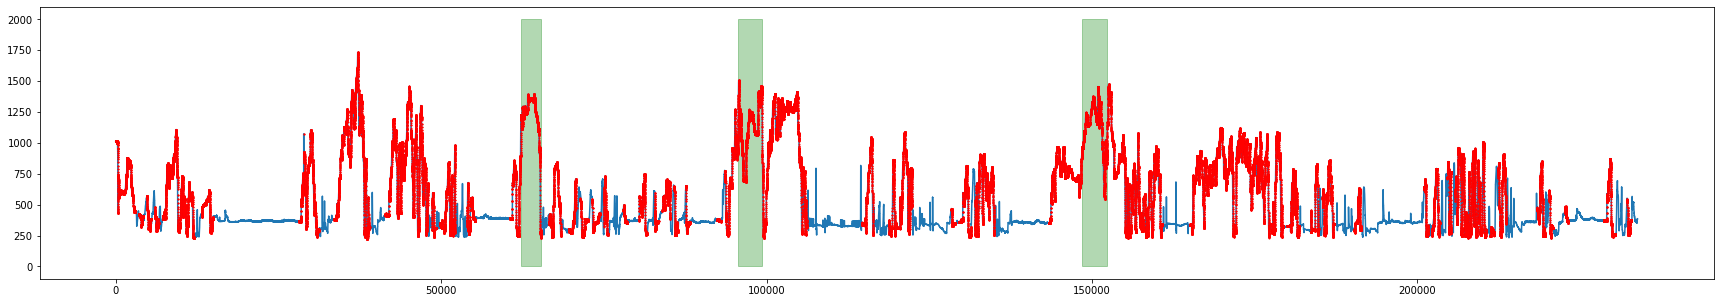

===== RECALL ======
1.0
====== ACCURACY =====
0.5248075278015398


<Figure size 432x288 with 0 Axes>

In [ ]:
config = easydict.EasyDict({
    "num_epochs" : 2, #500
    "batch_size" : 16, #16 
    "mode" : 'train',
    # "mode" : "test",
    "lr" : 1e-3, 
    "wd" : None,
    "window_size" : 1000,
    "stride" : 600,
    "threshold" : 0.3 # 0.3이나 0.2로 하기
})

tm = time.localtime(time.time())
string = time.strftime('%Y%m%d_%H%M%S', tm)

# wandb.init(project="Anomaly-Oil", entity="sohyun", name=string, magic=True)

train = pd.DataFrame(Fu_22_normal_10, columns=['Fu'])
train = pd.concat([train, pd.DataFrame(Fu_21_normal_10, columns=['Fu']), pd.DataFrame(Fu_20_normal_10, columns=['Fu'])], axis=0)
test = pd.DataFrame(Fu_22_abnormal_10, columns=['Fu'])
test_len = len(test)
total = pd.DataFrame(pd.concat([train, test], axis=0))

#---# Normalize를 안했을 때 #---#
# train_scale = train['Fu'].values
# test_scale = test['Fu'].values
# total_scale = total['Fu'].values

#---# Noramlize #---#
scaler = StandardScaler()
total_scale = scaler.fit_transform(total); total_scale = pd.DataFrame(total_scale, columns=['Fu'])['Fu'].values.tolist() # total 먼저 해놓고 transform
train_scale = scaler.transform(train); train_scale = pd.DataFrame(train_scale, columns=['Fu'])['Fu'].values.tolist()
test_scale = scaler.transform(test); test_scale = pd.DataFrame(test_scale, columns=['Fu'])['Fu'].values.tolist()

#---# Setting train data #---#
train_dataset = MyDataset(data=train_scale)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_dataset = MyDataset(data=test_scale)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# model = nn.DataParallel(AutoEncoder())
model = AutoEncoder()

optimizer = torch.optim.Adam(params = model.parameters(), lr = config.lr) # lr = config.lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, scheduler, device)
trainer.fit()
pred, x, _x = trainer.test(test_loader, config.threshold)
true_label = [0 for i in range(len(x))] # test_scale

##########################
#---# true list 만들기 #---#
##########################
true_label[62200:65300] = [1 for i in range(62200,65300)]
true_label[95600:99300] = [1 for i in range(95600,99300)]
true_label[148400:152300] = [1 for i in range(148400,152300)]

a = get_anomaly_time(x, pred)
recall, accuracy = calculate(true_label, a)

drawing(a, x, _x) # draw plot
print(f"===== RECALL ======\n{recall}\n====== ACCURACY =====\n{accuracy}")